In [1]:
import numpy as np 
import matplotlib.pyplot as plt
pi = np.pi
import copy
import scipy.linalg as scilinalg
from tqdm.notebook import tqdm
from scipy.integrate import quad
from scipy.optimize import fsolve
#from numba import jit
#import timeit
I = 1j

In [2]:
def round_matrix(mat): #function which rounds any matrix element with abs value <1e-12 to zero
    mat_rounded = copy.deepcopy(mat)
    for i in range(len(mat_rounded)):
        for j in range(len(mat_rounded[i])):
            if np.abs(np.real(mat_rounded[i,j]))  <1e-12:
                mat_rounded[i,j] = complex(0 , np.imag(mat_rounded[i,j]))

            if np.abs(np.imag(mat_rounded[i,j]))<1e-12:
                mat_rounded[i,j] = complex(np.real(mat_rounded[i,j]) , 0)

                
    
    return mat_rounded

############################################################################################################################################

def forward_difference(y , dx): #function for numerical differentiation using the forward difference formula
    if len(y) == 1:
        return 0
    dydx = np.array(len(y)*[0.00])
    for i in range(len(y)-1):
        dydx[i] = (y[i+1] - y[i])/(dx)
    
    dydx[-1] = (y[-1] - y[-2])/(dx)
    
    return dydx
        
##########################################################################################################################################    

def disc_pieces(x , y): #function to take a discontinuous piecewise function and return each of its pieces along with the size of each discontinuous jump 
    dy = np.array(len(y)*[0.00])
    num_discs = 0 #number of jumps
    size_jump = np.array([])  #size of the jump
    index_jump = np.array([] , dtype = int) #index AFTER which jump occurs
    
    for i in range(len(y)-1):
        dy[i] = (y[i+1] - y[i])
        
        if abs(dy[i]) >= np.pi:   #definining minimum size of a jump as pi
            #print("jump spotted")
            num_discs = num_discs + 1
            size_jump = np.append(size_jump , dy[i])
            #print(size_jump)
            index_jump = np.append(index_jump , i)
        
    
            
    #print(num_discs)
    function_subsets = (num_discs + 1)*[0.00]  #each element of this list will have a piece of the piecewise input function
    #print(len(function_subsets))
    #print(index_jump)
    
    if num_discs == 0:
        return y , 0
    
    starting_index = 0
    
    for i in range(len(function_subsets)-1):
        function_subsets[i] = y[starting_index:index_jump[i]+1]
        starting_index = index_jump[i]+1
    function_subsets[-1] = y[starting_index:]

    
    return function_subsets , size_jump
        
############################################################################################################################################
def nearest_multiple_of_pi(phase): #function to find the nearest multiple of pi
    if phase>=0:
        return (phase//pi)*pi
    else:
        return ((phase//pi)+1)*pi
    
############################################################################################################################################
    
def make_periodic(phase): #function to make the phase periodic between (-pi,pi]
    if nearest_multiple_of_pi(phase) >= 0:
        if (nearest_multiple_of_pi(phase)/pi)%2 == 0:
            return (phase - nearest_multiple_of_pi(phase))
        else:
            return -(pi - (phase - nearest_multiple_of_pi(phase)))
    else:
        if (nearest_multiple_of_pi(phase)/pi)%2 == 0:
            return (phase - nearest_multiple_of_pi(phase))
        else:
            return (pi + (phase - nearest_multiple_of_pi(phase)))
        


In [3]:
class DPT:
    def __init__(self , vi , wi , vf , wf , gamma):
        self.vi = vi
        self.wi = wi
        self.vf = vf 
        self.wf = wf
        self.gamma = gamma
        self.initial_params = (self.vi , self.wi , 0)
        self.final_params = (self.vf , self.wf , self.gamma)
        self.is_Gk_array_assigned = False
        self.is_PGP_array_assigned = False
        self.is_limit_rate_assigned = False
        self.are_nus_assigned = False
        #do you want to make t_array and k_array object parameters inside the class, instead of defined outside? You might want to keep it 
        #outside to maintain flexibility, but since you're defining self.Gk_array for use in future functions to save time, that reduces 
        #flexibility anyway since once you define a Gk array using a particular t_array and k_array, that same array is used in future  
        #functions also, removing your flexibility to use different t and k arrays for other functions. If you remove this reuse feature or
        #put a flag which gives you the choice whether to reuse or not, you can regain the flexibility, but seems needleslly complicated.
        #easier to eithe define t and k arrays inside only, or leave it outside and just use the same t and k arrays for all functions.  
        #self.t_array = t_array
        #self.k_array = k_array


    def set_params_with_deltas(self , delta_i , delta_f):
        self.vi = 1 - delta_i
        self.wi = 1 + delta_i

        self.vf = 1 - delta_f
        self.wf = 1 + delta_f

        self.delta_i = delta_i
        self.delta_f = delta_f

    def Hi(self , k): #function to generate the 2x2 SSH Hamiltonian H(k) with given v,w,gamma for a given value of k
     
        mat = np.zeros((2,2) , dtype = complex)
        mat[0,1] = self.vi + self.wi*np.exp(I*k)
        mat[1,0] = self.vi + self.wi*np.exp(-I*k)

        return mat
    
    def Hf(self , k): #function to generate the 2x2 SSH Hamiltonian H(k) with given v,w,gamma for a given value of k
     
        mat = np.zeros((2,2) , dtype = complex)
        mat[0,1] = self.vf + self.wf*np.exp(I*k)
        mat[1,0] = self.vf + self.wf*np.exp(self.gamma - I*k)

        return mat
    

    
    def biorth_VU(self , k , dagger = False):

        if dagger:
            eigs , vl , vr = scilinalg.eig(  np.matrix.getH(self.Hf(k)) , left = True , right = True  ) #get the eigenvalues and left & right eigenvectors

        else:
            eigs , vl , vr = scilinalg.eig(  self.Hf(k) , left = True , right = True  ) #get the eigenvalues and left & right eigenvectors



        left_evec_plus = vl[:,0] #important note: scipy returns the left evecs as bra vectors! I deal with that below
        left_evec_minus = vl[:,1]
        right_evec_plus = vr[:,0]
        right_evec_minus = vr[:,1]

        #I'm using the biorthogonal normalization condition described in the Brody paper.
        #Needed to conjugate the normalization factor here for the left-evecs because right now they are bras but in all
        #inner products they will be kets and therefore will be conjugated once again
        left_evec_plus_normed = np.conjugate(1/np.sqrt(np.vdot(left_evec_plus , right_evec_plus))) * left_evec_plus 
        left_evec_minus_normed = np.conjugate(1/np.sqrt(np.vdot(left_evec_minus ,right_evec_minus))) * left_evec_minus
        
        right_evec_plus_normed = (1/np.sqrt(np.vdot(left_evec_plus , right_evec_plus))) * right_evec_plus
        right_evec_minus_normed = (1/np.sqrt(np.vdot(left_evec_minus , right_evec_minus))) * right_evec_minus

        
        #Now to define the basis transformation matrices U and V. These are matricies whose product is unity and they also diagonalize 
        #the hamiltonian.
        #U = has the two right eigenkets of the hamiltonian as its columns
        #V = has the two left eigenbras of the hamiltonian as its rows
        columnV = np.zeros((2,2) , dtype = complex)
        newU = np.zeros((2,2) , dtype = complex)

        
        #remember, left_evec_plus_normed is still a ket vector, so i'll define the matrix comumnV whose columns 
        #are these ket vectors and then take its hermitian conjugate.
        columnV[:,0] = left_evec_plus_normed 
        columnV[:,1] = left_evec_minus_normed

        #taking hermitian conjugate of the columnV matrix now gets us the V matrix. 
        #newV is a matrix with the left eigenbras of the hamiltonian as its rows
        newV = np.matrix.getH(columnV) 

        newU[:,0] = right_evec_plus_normed #newU is a matrix with the right eigenkets of the hamiltonian as its columns
        newU[:,1] = right_evec_minus_normed

        return (eigs , newV , newU)


    def Gk(self , t , k ): #function to give the Gk value (term inside the  product in the Loschmidt Echo expression)
        
        kappa_i_pm , right_vecs_initial_mat = scilinalg.eig(  self.Hi(k) , left = False , right = True  ) #get eigenvectors of initial Hamiltonian

        right_eigenket_initial_minus = right_vecs_initial_mat[:,np.where(kappa_i_pm < 0)[0]] #the eigenvector corresponding to the negative eigenvalue
  
        left_eigenbra_initial_minus = np.transpose(np.conjugate(right_eigenket_initial_minus)) #the corresponding ket vector
  
        
        kappa_f_pm , Vf , Uf = self.biorth_VU(k)
        Hf = self.Hf(k)


        #left_eigenbra_initial_plus_in_Hf_eigenbasis = left_eigenbra_initial_plus@Uf
        left_eigenbra_initial_minus_in_Hf_eigenbasis = left_eigenbra_initial_minus@Uf

        #right_eigenket_initial_plus_in_Hf_eigenbasis = Vf@right_eigenket_initial_plus
        right_eigenket_initial_minus_in_Hf_eigenbasis = Vf@right_eigenket_initial_minus

        exp_Hf = np.zeros((2,2) , dtype = complex)
        exp_Hf[0,0] = np.exp(-I*t*kappa_f_pm[0])
        exp_Hf[1,1] = np.exp(-I*t*kappa_f_pm[1])

        HfDagger = np.matrix.getH(Hf)
        HfDagger_in_Hf_eigenbasis = Vf @ HfDagger @ Uf
        exp_HfDagger_in_Hf_eigenbasis = scilinalg.expm(I*t*HfDagger_in_Hf_eigenbasis)

        norm_term = np.sqrt( left_eigenbra_initial_minus_in_Hf_eigenbasis @ exp_HfDagger_in_Hf_eigenbasis @ exp_Hf @ right_eigenket_initial_minus_in_Hf_eigenbasis )


        #Gkk_right = exp_Hf @ right_eigenket_initial_minus_in_Hf_eigenbasis

        Gkk = (left_eigenbra_initial_minus_in_Hf_eigenbasis @ exp_Hf @ right_eigenket_initial_minus_in_Hf_eigenbasis)/norm_term

        return Gkk
    
    def return_rate(self , t_array , k_array): #function to calculate the Loschmidt Return Rate, formula in Ritu's paper (also below)
        
        if not self.is_Gk_array_assigned: #if Gk_array is not already assigned, I will use scipy quad function to calculate return rate
            def return_rate_integrand_for_quad(k , t): #This is the integrand for the return rate eqn, then use scipy quad to integrate.
                                                        #input variable k needs to go first for quad to integrate along k
                return (-1/(2*pi))*np.log( np.abs(self.Gk(t , k)) )
            
            limit_rate_using_quad = np.zeros(len(t_array))

            for i in tqdm(range(len(t_array))):
                limit_rate_using_quad[i] = quad(return_rate_integrand_for_quad , -pi , pi , args = (t_array[i]))[0]

            self.limit_rate = limit_rate_using_quad
            self.is_limit_rate_assigned = True
            
            return limit_rate_using_quad
        
        if self.is_Gk_array_assigned: #if Gk array is already assigned, I will directly perform numerical intergation using np.trapz on 
                                    #the Gk array to get the return rate. This should be faster if Gk is already assigned.
            limit_rate_using_trapz = -(1/(2*pi))*np.trapz(np.log(np.abs(self.Gk_array)) , k_array , axis=1)
            self.limit_rate = limit_rate_using_trapz #!!! reconsider this later: running this func twice might first set self.limit_rate
                                                    #as limit_rate_using_quad, and the next time as limit_rate_using_trapz! are you 
                                                    #ok with that? !!!
            
            self.is_limit_rate_assigned = True
            return limit_rate_using_trapz


    
    def get_Gk_array(self , t_array , k_array): #function to get a Gk(t,k) array for each value of t,k

        Gk_array = np.zeros((len(t_array) , len(k_array)) , dtype = complex)

        for i in tqdm(range(len(t_array))):
            for j in range(len(k_array)):
                Gk_array[i,j] = self.Gk(t_array[i] , k_array[j])

        self.Gk_array = Gk_array
        self.is_Gk_array_assigned = True #True if the Gk(t,k) array is already assigned. If true, i'll just use it directly 
                                        #to calculate the return rate and the PGP

        return Gk_array
    
        
    def dphi_dyn(self , t , k): #function to calculate the integrand of the phi_dyn expression (equation in Ritu's paper, also below)

        kappa_i_pm , right_vecs_initial_mat = scilinalg.eig(  self.Hi(k) , left = False , right = True  ) #get eigenvectors of initial Hamiltonian

        right_eigenket_initial_minus = right_vecs_initial_mat[:,np.where(kappa_i_pm < 0)[0]] #the eigenvector corresponding to the negative eigenvalue

        left_eigenbra_initial_minus = np.transpose(np.conjugate(right_eigenket_initial_minus)) #the corresponding ket vector
        
        kappa_f_pm , Vf , Uf = self.biorth_VU(k)
        Hf = self.Hf(k)

        #kappa_f_pm_Hdagger , Uf_Hdagger , Vf_Hdagger = self.biorth_VU(k , dagger = True)


        #left_eigenbra_initial_plus_in_Hf_eigenbasis = left_eigenbra_initial_plus@Uf
        left_eigenbra_initial_minus_in_Hf_eigenbasis = left_eigenbra_initial_minus@Uf

        #right_eigenket_initial_plus_in_Hf_eigenbasis = Vf@right_eigenket_initial_plus
        right_eigenket_initial_minus_in_Hf_eigenbasis = Vf@right_eigenket_initial_minus


        Hf_diagonal = np.zeros((2,2) , dtype = complex)
        Hf_diagonal[0,0] = kappa_f_pm[0]
        Hf_diagonal[1,1] = kappa_f_pm[1]

        exp_Hf_diagonal = np.zeros((2,2) , dtype = complex)
        exp_Hf_diagonal[0,0] = np.exp(-I*t*kappa_f_pm[0])
        exp_Hf_diagonal[1,1] = np.exp(-I*t*kappa_f_pm[1])

        HfDagger = np.matrix.getH(Hf)
        HfDagger_in_Hf_eigenbasis = Vf @ HfDagger @ Uf
        exp_HfDagger_in_Hf_eigenbasis = scilinalg.expm(I*t*HfDagger_in_Hf_eigenbasis)

        norm_term = np.sqrt( left_eigenbra_initial_minus_in_Hf_eigenbasis @ exp_HfDagger_in_Hf_eigenbasis @ exp_Hf_diagonal @ right_eigenket_initial_minus_in_Hf_eigenbasis )

        right_term = ( exp_Hf_diagonal @ right_eigenket_initial_minus_in_Hf_eigenbasis ) / norm_term

        left_term = ( left_eigenbra_initial_minus_in_Hf_eigenbasis @ exp_HfDagger_in_Hf_eigenbasis )/ norm_term

        dphi_dyn = -np.real(left_term @ Hf_diagonal @ right_term)

        return dphi_dyn
    
    def phi_dyn(self, t , k): #uses scipy.integrate.quad on the dphi_dyn output to get the value of phi_dyn
        phi_dyn = quad(self.dphi_dyn , 0 , t , args = (k))[0] #NOTE: resist the urge to combine the dphi_dyn and phi_dyn funcs into one func.
                                                        #I think doing that makes the PGP_array fun run crazy slow. Check later, but this 
        return phi_dyn                                  #works fine so just let it be.
    

    
    def PGP(self , t , k): #function to calculate the value of the PGP (using phi_LE and phi_dyn). phi_dyn was calculated above, while 
                            #phi_LE is obtained straighforwardly from Gk below.
        phi_LE = -I*np.log( self.Gk(t , k) / np.abs(self.Gk(t , k)) )
        phi_dyn = self.phi_dyn(t , k)

        if ( (np.imag(phi_LE) > 1e-10) ):
            raise Exception("Phases must be real, but here phi_LE is complex!")
        
        else:

            PGP = make_periodic(  make_periodic(np.real(phi_LE)) - make_periodic(np.real(phi_dyn))  )

        return PGP
    
    def get_PGP_array(self , t_array , k_array): #Function to create a whole array of PGP values corresponding to arrays of t and k values

        dphi_dyn_array = np.zeros( (len(t_array) , len(k_array))) #defining an array of dphi_dyn values

        for i in tqdm(range(len(t_array))):
            for j in range(len(k_array)):
                dphi_dyn_array[i,j] = self.dphi_dyn(t_array[i] , k_array[j])

        phi_dyn_array = np.zeros((len(t_array) , len(k_array))) #integrating the dphi_dyn values wrt time to get phi_dyn values

        for i in tqdm(range(len(t_array))):
            phi_dyn_array[i] = np.trapz(dphi_dyn_array[:i] , t_array[:i] , axis = 0)

        phi_LE_array = np.zeros((len(t_array) , len(k_array)))  #defining an array of phi_LE values

        if self.is_Gk_array_assigned: #if the Gk array is already assigned, use it directly to make a phi_LE array, it will be much faster
            for i in tqdm(range(len(t_array))):
                for j in range(len(k_array)):
                    phi_LE_array[i,j] = -I*np.log( self.Gk_array[i,j] / np.abs(self.Gk_array[i,j]) )
        
        if not self.is_Gk_array_assigned: #if Gk array is not assigned, then use the Gk(t,k) function to calculate individual phi_LE values
                                        #to assign to each array element
            for i in tqdm(range(len(t_array))):
                for j in range(len(k_array)):
                    phi_LE_array[i,j] = -I*np.log( self.Gk(t_array[i] , k_array[j]) / np.abs(self.Gk(t_array[i] , k_array[j])) )[0][0]



        PGP_array = np.zeros((len(t_array) , len(k_array))) #now putting it all together in an array of PGP values
        
        for i in tqdm(range(len(t_array))):
            for j in range(len(k_array)):
                PGP_array[i,j] = make_periodic(  make_periodic(np.real(phi_LE_array[i,j])) - make_periodic(phi_dyn_array[i,j])  ) 
                                                    #the make_periodic function makes sure the values are periodic and cycle between (-pi,pi].
                                                    #while the phase definitions might already take care of that, in some cases (like Hermitian
                                                    #limit) they didn't, so these functions are just meant to be a failsafe
        
        self.PGP_array = PGP_array
        self.is_PGP_array_assigned = True
        
        return PGP_array
    
    def DTOP(self , t_array , k_array): #function to calculate the DTOP in the -ve and +ve momentum spaces
        if self.is_PGP_array_assigned:
            PGP = self.PGP_array
        if not self.is_PGP_array_assigned:
            PGP = self.get_PGP_array(t_array , k_array)
        
        PGP_plus = PGP[: , np.where(k_array==0)[0][0]:] #for non-Hermitian case there are two distinct DTOPs for the negative and positive 
                                                        #momenta, thus defining a PGP_plus/minus and later a DTOP_plus/minus 

        PGP_minus = PGP[: , :np.where(k_array==0)[0][0]]

        kp = k_array[np.where(k_array==0)[0][0]:]
        km = k_array[:np.where(k_array==0)[0][0]]

        dk = k_array[1] - k_array[0]

        ########################################################

        pieces_plus = len(PGP_plus)*[0.00]
        jump_sizes_plus = len(PGP_plus)*[0.00]

        for i in range(len(PGP_plus)):#in the k>0 space, for each t value, how many pieces does the piecewise PGP function have, and 
                                        # what are the sizes of the discontinuous jumps?
            pieces_plus[i] , jump_sizes_plus[i] = disc_pieces( kp , PGP_plus[i] )

        ##################################################################################

        dnu_plus = len(PGP_plus)*[0.00]

        for i in range(len(dnu_plus)): #the DTOP formula involves first differentiating the PGP wrt k. That's what I'm doing here
            if not np.shape(jump_sizes_plus[i]): #if there is no jump...
                dnu_plus[i] = forward_difference(pieces_plus[i] , dk)
                
            else:  #if there is a nonzero number of jumps
                dnu_plus[i] = [forward_difference(arr , dk) for arr in pieces_plus[i]]
                
                
        ##################################################################################

        nu_plus = len(PGP_plus)*[0.00]

        for i in range(len(nu_plus)): #now to get nu from dnu, need to integrate wrt k. 
            if not np.shape(jump_sizes_plus[i]): #if there is no jump, we perform the k integration directly
                nu_plus[i] = (-1/(2*pi))*np.trapz(pieces_plus[i] , dx = dk)
                
            else:  #if there is a nonzero number of jumps, we integrate the differentiable pieces of the nondifferentiable dnu function 
                #separately, and then add the jump amplitudes to the integral separately.
                #integral of the derivative of a piecewise function gives a step function, which doesn't show up in numerical calculus,
                #thus I'm adding in the step function manually by adding in the jumps.
                nu_plus[i] = (-1/(2*pi))*(np.sum([np.trapz(arr , dx = dk) for arr in pieces_plus[i]]) + np.sum(jump_sizes_plus[i]))
        

        ######################################################################################

        #Now repeating the exact things I did above, but now for the k<0 regime instead of the k>0 regime.     
        pieces_minus = len(PGP_minus)*[0.00]
        jump_sizes_minus = len(PGP_minus)*[0.00]

        for i in range(len(PGP_minus)):
            #print("index = ",i)
            pieces_minus[i] , jump_sizes_minus[i] = disc_pieces( km , PGP_minus[i] )

        ########################################################################################
            
        dnu_minus = len(PGP_minus)*[0.00]

        for i in range(len(dnu_minus)):
            if not np.shape(jump_sizes_minus[i]): #if there is no jump...
                dnu_minus[i] = forward_difference(pieces_minus[i] , dk)
                
            else:  #if there is a nonzero number of jumps
                dnu_minus[i] = [forward_difference(arr , dk) for arr in pieces_minus[i]]
                
                
        #########################################################################################
                

        nu_minus = len(PGP_minus)*[0.00]

        for i in range(len(nu_minus)):
            if not np.shape(jump_sizes_minus[i]): #if there is no jump...
                nu_minus[i] = -(-1/(2*pi))*np.trapz(pieces_minus[i] , dx = dk) #this integral is being done from -pi to 0, so i added an extra minus sign at the front so that the integral is effectively from 0 to -pi
                
            else:  #if there is a nonzero number of jumps
                nu_minus[i] = -(-1/(2*pi))*(np.sum([np.trapz(arr , dx = dk) for arr in pieces_minus[i]]) + np.sum(jump_sizes_minus[i]))

        self.nu_plus = nu_plus #should i assign an object parameter here or only return a value for the function? This is something I 
        self.nu_minus = nu_minus #need to decide for other functions in this class also.

        self.are_nus_assigned = True

        return nu_plus , nu_minus
    
    def di(self , k):
        return np.array([self.vi + self.wi*np.cos(k) , -self.wi*np.sin(k)])
    
    def df(self , k):
        return np.array([self.vf + self.wf*np.exp(self.gamma/2)*np.cos(k + I*self.gamma/2) , -self.wf*np.exp(self.gamma/2)*np.sin(k + I*self.gamma/2)])
    
    def get_di_array(self, k_array):
        di_array = np.zeros(len(k_array) , dtype = complex)
        for i in range(len(k_array)):
            di_array[i] = self.di(k_array[i])
    
    def get_df_array(self , k_array):
        df_array = np.zeros(len(k_array) , dtype = complex)
        for i in range(len(k_array)):
            df_array[i] = self.df(k_array[i])

    def Efk(self , k):
        Efk = np.sqrt(np.dot(self.df(k) , self.df(k)))
        return Efk
    
    def Eik(self , k):
        Eik = np.sqrt(np.dot(self.di(k) , self.di(k)))
        return Eik
    
    def get_Efk_array(self , k_array):
        Efk_array = np.zeros(len(k_array) , dtype = complex)
        for i in range(len(k_array)):
            Efk_array[i] = self.Efk(k_array[i])
        return Efk_array

    def get_Eik_array(self , k_array):
        Eik_array = np.zeros(len(k_array) , dtype = complex)
        for i in range(len(k_array)):
            Eik_array[i] = self.Eik(k_array[i])
        return Eik_array

            
    def cos_delta_k(self , k):
        di_normed = (1/np.sqrt(np.dot(self.di(k) , self.di(k))))*self.di(k)
        df_normed = (1/np.sqrt(np.dot(self.df(k) , self.df(k))))*self.df(k)
        return np.dot( di_normed , df_normed )
    
    def get_cos_delta_k_array(self , k_array):
        cos_delta_k_array = np.zeros(len(k_array) , dtype = complex)
        for i in range(len(k_array)):
            cos_delta_k_array[i] = self.cos_delta_k(k_array[i])
        return cos_delta_k_array
    
    def w(self , n , k):
        w = I*((2*n+1)*pi)/(2*self.Efk(k)) - (1/self.Efk(k))*np.arctanh(self.cos_delta_k(k))
        return w
    
    def get_w_array(self , n , k_array):
        w_array = np.zeros(len(k_array) , dtype = complex)
        for i in range(len(k_array)):
            w_array[i] = self.w(n , k_array[i])
        return w_array

    
    def kctc(self , n , k_array):

        kplus = k_array[np.where(k_array>=0)]
        kminus = k_array[np.where(k_array<0)]

        Efk_arr_kplus = self.get_Efk_array(kplus)
        Efk_arr_kminus = self.get_Efk_array(kminus)

        cos_delta_k_arr_kplus = self.get_cos_delta_k_array(kplus)
        cos_delta_k_arr_kminus = self.get_cos_delta_k_array(kminus)

        kc_eqn_kplus = pi*(n + 1/2)*np.imag(Efk_arr_kplus) - np.real(Efk_arr_kplus*np.arctanh(cos_delta_k_arr_kplus))
        kc_eqn_kminus = pi*(n + 1/2)*np.imag(Efk_arr_kminus) - np.real(Efk_arr_kminus*np.arctanh(cos_delta_k_arr_kminus))

        kcplus_index = np.where(abs(kc_eqn_kplus) == min( abs(kc_eqn_kplus) ))
        kcminus_index = np.where(abs(kc_eqn_kminus) == min( abs(kc_eqn_kminus) ))

        kc_plus = kplus[kcplus_index]
        kc_minus = kminus[kcminus_index]

        tc_plus = (pi*(n + 1/2)*np.real(Efk_arr_kplus[kcplus_index]) - np.imag( Efk_arr_kplus[kcplus_index]*np.arctanh(cos_delta_k_arr_kplus[kcplus_index]) ) )/(np.abs(Efk_arr_kplus[kcplus_index])**2)
        tc_minus = (pi*(n + 1/2)*np.real(Efk_arr_kminus[kcminus_index]) - np.imag( Efk_arr_kminus[kcminus_index]*np.arctanh(cos_delta_k_arr_kminus[kcminus_index]) ) )/(np.abs(Efk_arr_kminus[kcminus_index])**2)

        return [(kc_plus , kc_minus) , (tc_plus , tc_minus)]


        

    
    # def kctc(self , n , k_array):
    #     kappa_f = self.get_Efk_array(k_array)
    #     cos_delta_k = self.get_cos_delta_k_array(k_array)
    #     w = I*(pi*(2*n+1))/(2*kappa_f) - (1/kappa_f)*np.arctanh(cos_delta_k)
    #     kc_index = np.where(np.abs(np.real(w)) == min(np.abs(np.real(w))))
    #     kc = k_array[kc_index]

    #     tc = np.imag(w[kc_index])

    #     return kc , tc
    
    def plot_summary(self , t_array , k_array):

        if self.is_PGP_array_assigned:
            PGP = self.PGP_array
        if not self.is_PGP_array_assigned:
            PGP = self.get_PGP_array(t_array , k_array)

        tc0p = self.kctc(0 , k_array)[1][0][0]
        tc0m = self.kctc(0 , k_array)[1][1][0]

        tc1p = self.kctc(1 , k_array)[1][0][0]
        tc1m = self.kctc(1 , k_array)[1][1][0]

        tc2p = self.kctc(2 , k_array)[1][0][0]
        tc2m = self.kctc(2 , k_array)[1][1][0]

        tc3p = self.kctc(3 , k_array)[1][0][0]
        tc3m = self.kctc(3 , k_array)[1][1][0]

        tc4p = self.kctc(4 , k_array)[1][0][0]
        tc4m = self.kctc(4 , k_array)[1][1][0]


        fig , axs = plt.subplots( 2 , 2 , figsize = (8,8))
        fig.suptitle(r'DTOP, $\delta_i = %0.2f, \delta_f = %0.2f, \theta = %0.2f$' %(self.delta_i , self.delta_f , self.gamma)) 
        img00 = axs[0,0].pcolormesh(k_array/pi , t_array , np.real(PGP) , cmap = 'rainbow')
        #axs[0,0].set_ylim(1,4000)
        axs[0,0].set_title('PGP')
        plt.colorbar(img00 , ax = axs[0,0] , label = "PGP")
        axs[0,0].set_ylim(0,10)
        #img00.set_clim(-8,0)

        if self.is_limit_rate_assigned:
            limit_rate = self.limit_rate
        if not self.is_limit_rate_assigned:
            limit_rate = self.return_rate(t_array , k_array)

        axs[0,1].plot(t_array , limit_rate )
        #axs[0,1].set_yscale('log')
        axs[0,1].set_xlim(0,6)
        axs[0,1].set_ylim(0,0.7)
        axs[0,1].set_title('Loschmidt Return Rate')
        axs[0,1].grid()
        axs[0,1].axvline(tc0p , color='red')
        axs[0,1].axvline(tc0m , color='red')

        axs[0,1].axvline(tc1p , color='red')
        axs[0,1].axvline(tc1m , color='red')

        axs[0,1].axvline(tc2p , color='red')
        axs[0,1].axvline(tc2m , color='red')

        axs[0,1].axvline(tc3p , color='red')
        axs[0,1].axvline(tc3m , color='red')

        axs[0,1].axvline(tc4p , color='red')
        axs[0,1].axvline(tc4m , color='red')

        axs[0,1].set_ylabel(r'$g(t)$')
        axs[0,1].set_xlabel(r'$t$')

        if self.are_nus_assigned:
            nu_plus = self.nu_plus
            nu_minus = self.nu_minus
        if not self.are_nus_assigned:
            nu_plus , nu_minus = self.DTOP(t_array , k_array)


        axs[1,0].plot(t_array , np.array(nu_plus) )
        axs[1,0].set_xlim(0,6)
        axs[1,0].set_title('Loschmidt Return Rate')
        axs[1,0].grid()
        axs[1,0].set_ylabel(r'$\nu_{D}(t)$')
        axs[1,0].set_xlabel(r'$t$')
        axs[1,0].set_yticks([0,1,2,3,4,5])
        axs[1,0].set_xticks([tc0p , tc1p , tc2p , tc3p , tc4p])
        axs[1,0].set_ylim(-1 , 5)
        #axs[1,0].set_xlim(0,6)
        axs[1,0].set_title(r"$\nu_{+}(t)$")

        axs[1,1].plot(t_array , np.array(nu_minus) )
        axs[1,1].set_xlim(0,6)
        axs[1,1].set_title('Loschmidt Return Rate')
        axs[1,1].grid()
        axs[1,1].set_ylabel(r'$\nu_{D}(t)$')
        axs[1,1].set_xlabel(r'$t$')
        axs[1,1].set_yticks([0,1,2,3,4,5])
        axs[1,1].set_xticks([tc0m , tc1m , tc2m , tc3m , tc4m])
        axs[1,1].set_ylim(-1 , 5)
        #axs[1,1].set_xlim(0,6)
        axs[1,1].set_title(r"$\nu_{-}(t)$")



        plt.tight_layout()



    




In [4]:
t_array = np.linspace(0,30,500)
k_array = np.linspace(-pi , pi , 501)

In [5]:
T_to_NT = DPT(0,0,0,0,0.4)
T_to_NT.set_params_with_deltas(-0.9 , 0.9)

In [6]:
w_arr = T_to_NT.get_w_array(0 , k_array)

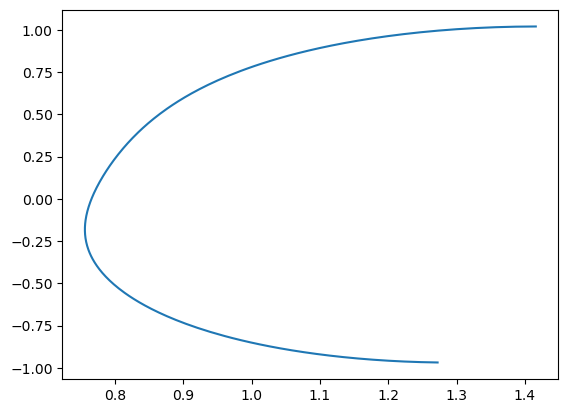

In [7]:
plt.plot(np.imag(w_arr[np.where(k_array>0)]) , np.real(w_arr[np.where(k_array>0)]))

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5124\2644974855.py:268: ComplexWarning: Casting complex values to real discards the imaginary part
  phi_LE_array[i,j] = -I*np.log( self.Gk(t_array[i] , k_array[j]) / np.abs(self.Gk(t_array[i] , k_array[j])) )[0][0]


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

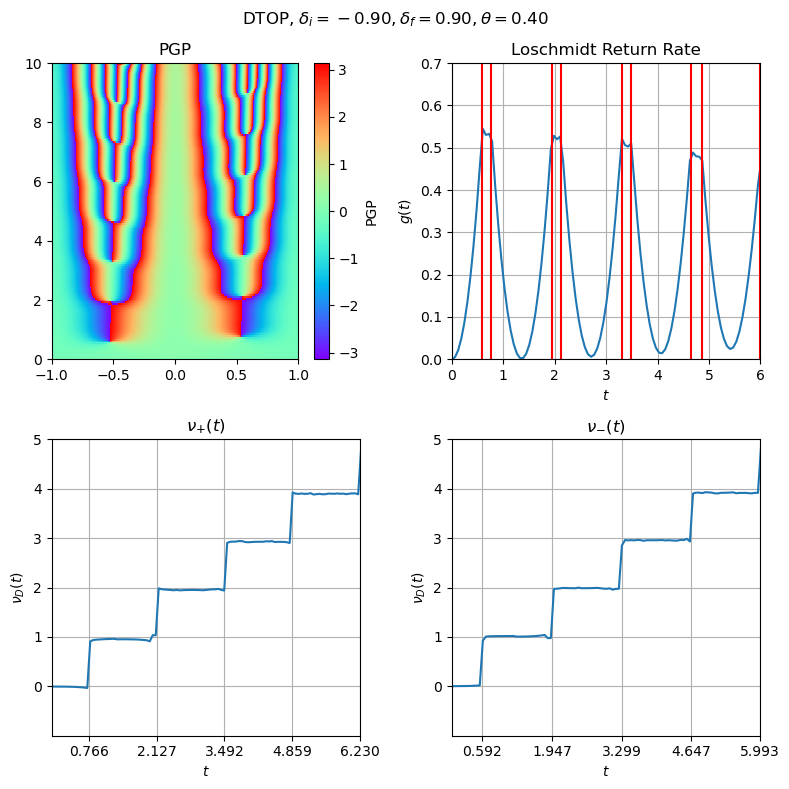

In [8]:
T_to_NT.plot_summary(t_array , k_array)

In [9]:
T_to_NT.kctc(0 , k_array)[1][0][0]

0.7656989336909993

In [22]:
E = T_to_NT.Eik(pi/3)
K = T_to_NT.Efk(pi/3)

cdk = T_to_NT.cos_delta_k(pi/3)

In [23]:
print(T_to_NT.cos_delta_k(pi/3))

(0.5798151718790473-0.16179525278195162j)


In [25]:
x = (E**2 + K**2)/(2*E*K)
print(x)

(1.019142412000384-0.0014133015042833168j)


In [21]:
x - cdk

(-0.07024396587885529+0.1654559866552698j)

In [16]:
K*np.conj(K)/E**2

(1.4784230660782607+0j)